# Import required packages

In [2]:
import numpy as np
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import glob
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import sklearn.metrics as metrics
import csv
from tensorflow.keras.callbacks import TensorBoard
# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Load the images and split into Train, validation and Test

In [9]:
def load_dataset(datasetname):
    print("*************************************************")
    print("\t\t" + datasetname + " Dataset is loaded...")

    image_directory = f"{datasetname}/testing/"
    SIZE = 224

    dataset = []  
    label = []  

    for i in range(1, 13):
        for file in sorted(glob.glob(f"{datasetname}/testing/anomaly/{i}/*.jpg")):
            image = cv2.imread(file)
            image = Image.fromarray(image, 'RGB').resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(1)

    for i in range(1, 18):
        for file in sorted(glob.glob(f"{datasetname}/testing/nonanomaly/{i}/*.jpg")):
            image = cv2.imread(file)
            image = Image.fromarray(image, 'RGB').resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(0)

    dataset = np.array(dataset)
    label = np.array(label)

    # Split into train and test data sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

    # Normalize data
    X_train = X_train / 255.
    X_test = X_test / 255.

    # Convert labels to categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    print("\n********************* Data shapes *************************")
    print(f"The {datasetname} dataset contains {len(dataset)} images")
    print("X_train.shape:", X_train.shape)
    print("y_train.shape:", y_train.shape)
    print("X_test.shape:", X_test.shape)
    print("y_test.shape:", y_test.shape)
    print("***********************************************************")

    return X_train, X_test, y_train, y_test

# Load the dataset
datasetname = 'ped2'
batch_size = 4
X_train, X_test, y_train, y_test = load_dataset(datasetname)

#  Save as NumPy arrays
np.save(datasetname+'/X_train.npy', X_train)
np.save(datasetname+'/y_train.npy', y_train)
np.save(datasetname+'/X_test.npy', X_test)
np.save(datasetname+'/y_test.npy', y_test)

*************************************************
		ped2 Dataset is loaded...

********************* Data shapes *************************
The ped2 dataset contains 3360 images
X_train.shape: (2688, 224, 224, 3)
y_train.shape: (2688, 2)
X_test.shape: (672, 224, 224, 3)
y_test.shape: (672, 2)
***********************************************************


# Load Numpy arrays (if required) 

In [3]:
# Load NumPy arrays
X_train = np.load(datasetname+'/X_train.npy')
y_train = np.load(datasetname+'/y_train.npy')
X_test = np.load(datasetname+'/X_test.npy')
y_test = np.load(datasetname+'/y_test.npy')

print("\n********************* Data shapes *************************")
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
print("***********************************************************")


********************* Data shapes *************************
X_train.shape: (2688, 224, 224, 3)
y_train.shape: (2688, 2)
X_test.shape: (672, 224, 224, 3)
y_test.shape: (672, 2)
***********************************************************


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
epochs = 20
input_img = Input(shape=(224, 224, 3))

# 1st layer
layer_1 = Conv2D(16, (1, 1), padding='same', activation='relu', name='block1_conv1_1')(input_img)
layer_1 = Conv2D(16, (1, 1), padding='same', activation='relu', strides=2, name='block1_conv2_1')(layer_1)

# 2nd layer
layer_2 = Conv2D(16, (5, 5), padding='same', activation='relu', name='block1_conv1_2')(input_img)
layer_2 = Conv2D(16, (5, 5), padding='same', activation='relu', strides=2, name='block1_conv2_2')(layer_2)

# 3rd layer
layer_3 = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block1_max')(input_img)
layer_3 = Conv2D(16, (3, 3), padding='same', activation='relu', name='block1_conv2_3')(layer_3)

# Concatenate
mid_1 = concatenate([layer_1, layer_2, layer_3], axis=3, name='concatenate1')

# 1st layer
layer_11 = Conv2D(16, (1, 1), padding='same', activation='relu', name='block2_conv1_1')(mid_1)
layer_11 = Conv2D(16, (1, 1), padding='same', activation='relu', strides=2, name='block2_conv2_1')(layer_11)

# 2nd layer
layer_21 = Conv2D(16, (5, 5), padding='same', activation='relu', name='block2_conv1_2')(mid_1)
layer_21 = Conv2D(16, (5, 5), padding='same', activation='relu', strides=2, name='block2_conv2_2')(layer_21)

# 3rd layer
layer_31 = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_max')(mid_1)
layer_31 = Conv2D(16, (3, 3), padding='same', activation='relu', name='block2_conv2_3')(layer_31)

# Concatenate
mid_11 = concatenate([layer_11, layer_21, layer_31], axis=3, name='concatenate2')

flat_1 = Flatten(name='flatten')(mid_11)
dense_1 = Dense(500, activation='relu', name='dense_1')(flat_1)
dense_2 = Dense(300, activation='relu', name='dense_2')(dense_1)
dense_3 = Dense(150, activation='relu', name='dense_3')(dense_2)
output = Dense(2, activation='sigmoid', name='dense_4')(dense_3)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define the checkpoint callback to save the best model based on validation loss
checkpoint_filepath = f"{datasetname}/best_model.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',  # Monitor validation loss for saving the best model
    save_best_only=True,  # Save only the best model
    mode='min',  # Minimize the monitored quantity (validation loss)
    verbose=1  # Print messages about saving the model
)

# Record the start time for training
train_start_time = time.time()

# Train the model with checkpointing
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[checkpoint_callback]  # Include the checkpoint callback
)

train_end_time = time.time()
# Calculate and print the training time
train_time = train_end_time - train_start_time
print("\n****************Model details *************************")
print(model.summary())
print("Training Time:", train_time, "seconds")
print("Best model saved at", checkpoint_filepath)

# Optionally load the best model after training
# best_model = load_model(checkpoint_filepath)

Epoch 1/20
538/538 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9912
Epoch 1: val_loss improved from inf to 0.99349, saving model to ped2\best_model.h5
538/538 [==============================] - 16s 28ms/step - loss: 0.0324 - accuracy: 0.9912 - val_loss: 0.9935 - val_accuracy: 0.8457
Epoch 2/20
538/538 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9949
Epoch 2: val_loss improved from 0.99349 to 0.00704, saving model to ped2\best_model.h5
538/538 [==============================] - 15s 28ms/step - loss: 0.0120 - accuracy: 0.9949 - val_loss: 0.0070 - val_accuracy: 0.9981
Epoch 3/20
538/538 [==============================] - ETA: 0s - loss: 5.7931e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00704
538/538 [==============================] - 11s 20ms/step - loss: 5.7931e-04 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 0.9981
Epoch 4/20
538/538 [==============================] - ETA: 0s - loss: 0.0057 - accuracy:

                                )                                                                 
                                                                                                  
 concatenate1 (Concatenate)     (None, 112, 112, 48  0           ['block1_conv2_1[0][0]',         
                                )                                 'block1_conv2_2[0][0]',         
                                                                  'block1_conv2_3[0][0]']         
                                                                                                  
 block2_conv1_1 (Conv2D)        (None, 112, 112, 16  784         ['concatenate1[0][0]']           
                                )                                                                 
                                                                                                  
 block2_conv1_2 (Conv2D)        (None, 112, 112, 16  19216       ['concatenate1[0][0]']           
          

# Plot the training and validation accuracy and loss at each epoch

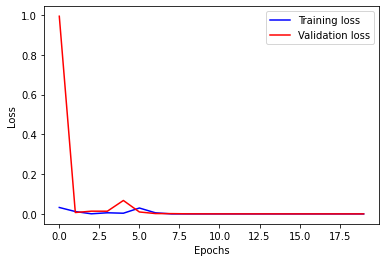

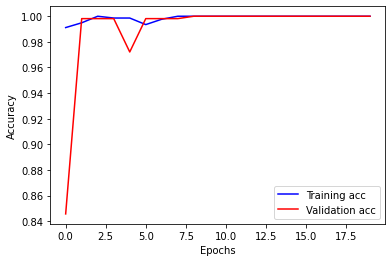

21/21 [==============================] - 1s 19ms/step - loss: 0.0133 - accuracy: 0.9940
Evaluation Time: 1.063307285308838 seconds
Accuracy = 99.40%


<Figure size 432x288 with 0 Axes>

In [15]:
# Plot and save training/validation loss
plt.plot(history.history['loss'], 'blue', label='Training loss')
plt.plot(history.history['val_loss'], 'red', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(f'{datasetname}/Loss_{epochs}.png', bbox_inches='tight', dpi=1080)
plt.clf()

# Plot and save training/validation accuracy
plt.plot(history.history['accuracy'], 'blue', label='Training acc')
plt.plot(history.history['val_accuracy'], 'red', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig(f'{datasetname}/Accuracy_{epochs}.png', bbox_inches='tight', dpi=1080)
plt.clf()

# Evaluate the model on the test data
test_start_time = time.time()
_, test_acc = model.evaluate(X_test, y_test)
test_end_time = time.time()
test_time = test_end_time - test_start_time

print("Evaluation Time:", test_time, "seconds")
print(f"Accuracy = {test_acc * 100.0:.2f}%")


In [16]:
feature_embeddings = model.predict(X_test,batch_size=1)
y_pred = np.argmax(feature_embeddings, axis=1)
y_true = np.argmax(y_test, axis=1)

672/672 [==============================] - 2s 3ms/step


# Save samples of original and predicted images

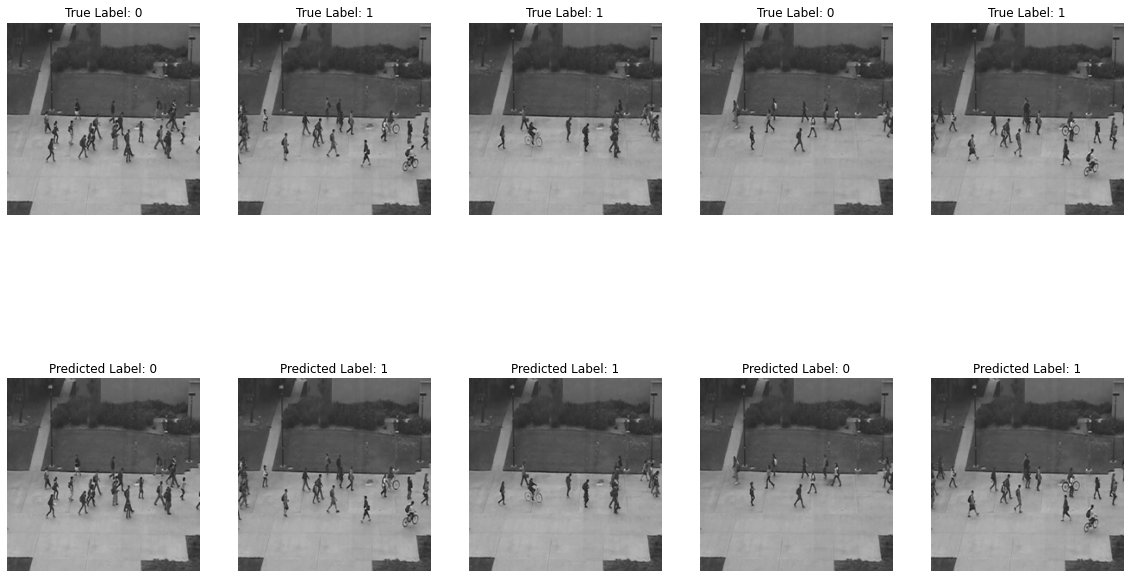

<Figure size 432x288 with 0 Axes>

In [18]:
def plot_orig_pred(y_true, y_pred, X_test, datasetname, epochs):
    num_images_to_plot = 5
    random_indices = np.random.choice(X_test.shape[0], num_images_to_plot, replace=False)
    
    # Plot original and predicted images
    fig, axes = plt.subplots(2, num_images_to_plot, figsize=(20, 12))

    for i, idx in enumerate(random_indices):
        # Display the original image with true label on top
        axes[0, i].imshow(X_test[idx])
        axes[0, i].set_title("True Label: " + str(y_true[idx]), fontsize=12)
        axes[0, i].axis('off')
        
        # Display the original image with predicted label on top
        axes[1, i].imshow(X_test[idx])
        axes[1, i].set_title("Predicted Label: " + str(y_pred[idx]), fontsize=12)
        axes[1, i].axis('off')

    # Save the plot as separate images
    plt.savefig(f'{datasetname}/{datasetname}_original_predicted_{epochs}.png', bbox_inches='tight')
    plt.show()
    plt.clf()

# Call the function to plot original and predicted images
plot_orig_pred(y_true, y_pred, X_test, datasetname, epochs)


# plot weight distributions

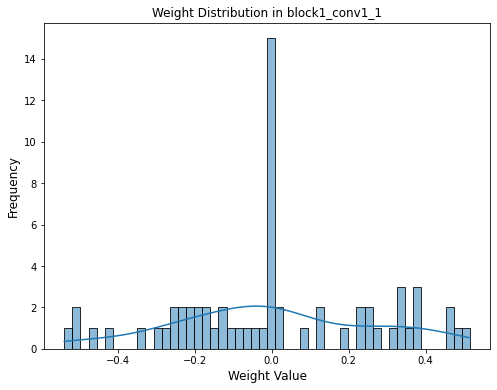

<Figure size 432x288 with 0 Axes>

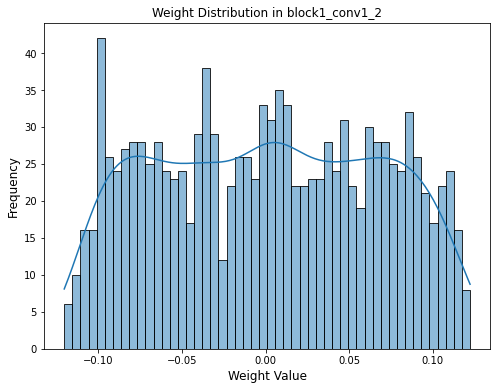

<Figure size 432x288 with 0 Axes>

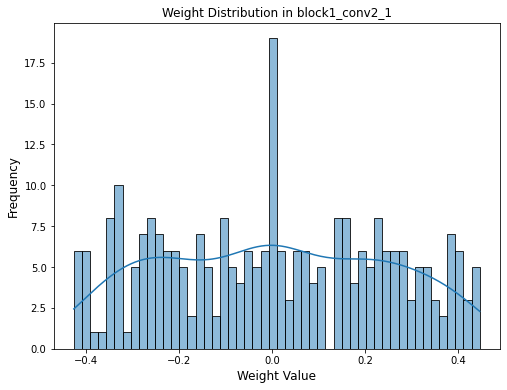

<Figure size 432x288 with 0 Axes>

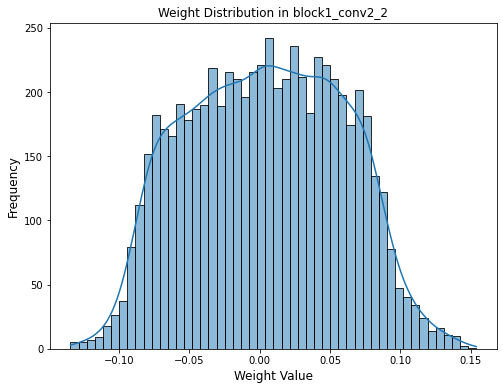

<Figure size 432x288 with 0 Axes>

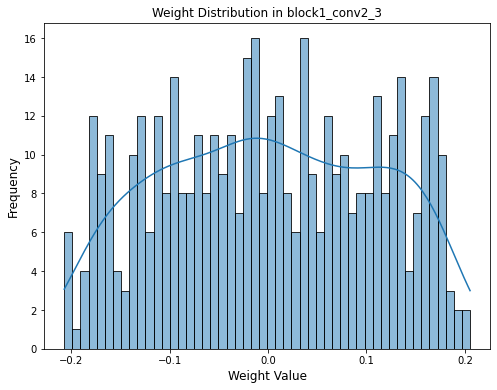

<Figure size 432x288 with 0 Axes>

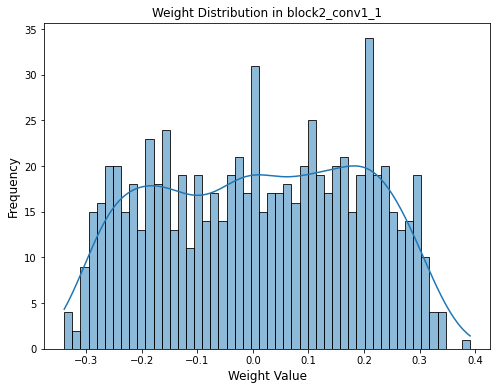

<Figure size 432x288 with 0 Axes>

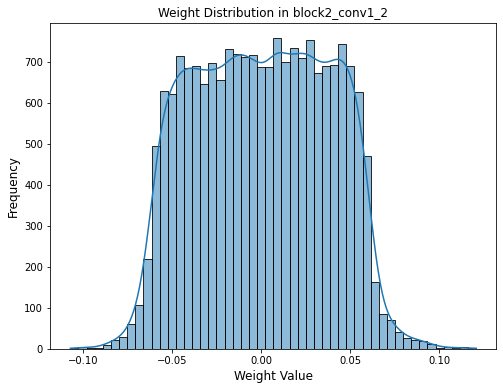

<Figure size 432x288 with 0 Axes>

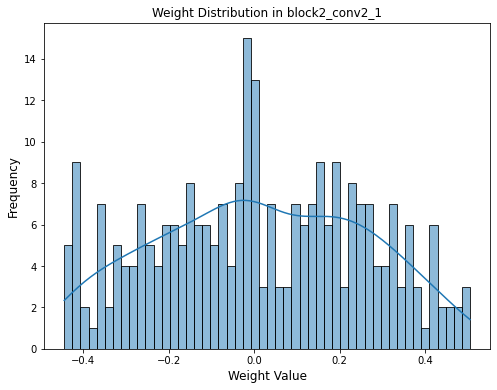

<Figure size 432x288 with 0 Axes>

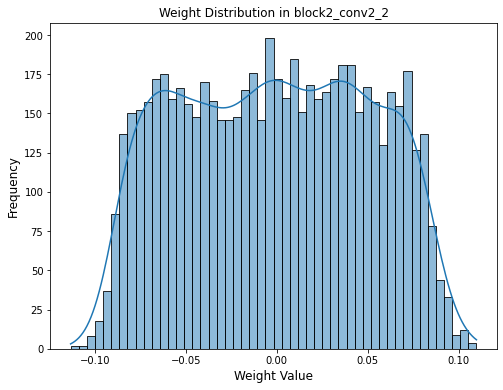

<Figure size 432x288 with 0 Axes>

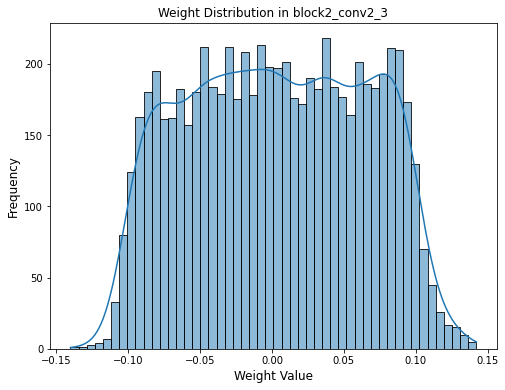

In [ ]:
if not os.path.exists(datasetname+'/weight_dist_'+str(epochs)):
    os.makedirs(datasetname+'/weight_dist_'+str(epochs))

# Function to plot weight distributions
def plot_weight_distributions(model):
    for layer in model.layers:
        if isinstance(layer, (Conv2D, Dense)):
            weights = layer.get_weights()
            if weights:
                flattened_weights = [w.flatten() for w in weights]
                all_weights = np.concatenate(flattened_weights)
                plt.figure(figsize=(8, 6))
                sns.histplot(all_weights, bins=50, kde=True)
                plt.title(f'Weight Distribution in {layer.name}', fontsize=12)
                plt.xlabel('Weight Value',fontsize=12)
                plt.ylabel('Frequency',fontsize=12)
                plt.show()
                plt.savefig(datasetname+'/weight_dist_'+str(epochs)+'/'+str(layer.name)+'.png', bbox_inches='tight')
                plt.cla()
                plt.clf()
plot_weight_distributions(model)


# Print Classification metrics

**************Print all classification metrics*****************
Classification Metrics:
Accuracy: 0.9955
Precision: 0.9940
Recall: 0.9970
F1 Score: 0.9955
Confusion Matrix:
[[337   2]
 [  1 332]]


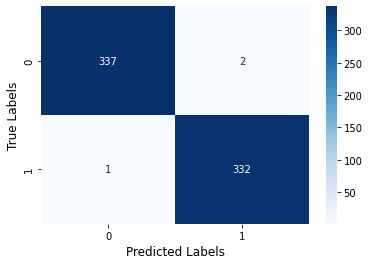

<Figure size 432x288 with 0 Axes>

In [16]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
cm = confusion_matrix(y_true, y_pred)  
print("**************Print all classification metrics*****************")
print("Classification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.savefig(datasetname+'/plot_confusion_matrix'+str(epochs)+'.png', bbox_inches='tight')
plt.figure()
plt.cla()
plt.clf()

# Plot ROC curve and print AUC and EER

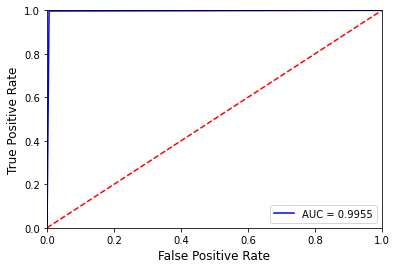

Area under ROC curve is: 0.9955486459911238
Equal Error Rate (EER): 0.002896702011746216


<Figure size 432x288 with 0 Axes>

In [8]:
fpr, tpr, threshold = metrics.roc_curve(y_true,y_pred)
roc_auc = metrics.auc(fpr, tpr)
#plt.title(label="Receiver Operating Characteristic", color='red')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=12)
plt.xlabel('False Positive Rate',fontsize=12)
plt.show()
plt.savefig(datasetname+'/ROC_'+str(epochs)+'.png', bbox_inches='tight')
plt.cla()
plt.clf() 

# Calculate EER
eer = 1.0
for i in range(len(fpr)):
    if abs(fpr[i] - (1 - tpr[i])) < eer:
        eer = abs(fpr[i] - (1 - tpr[i]))

# Print AUC, EER value
print("Area under ROC curve is:",roc_auc)
print("Equal Error Rate (EER):", eer)


# Plot t-sne plot

21/21 [==============================] - 0s 18ms/step


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


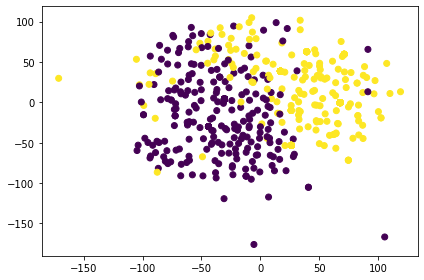

<Figure size 432x288 with 0 Axes>

In [13]:
if not os.path.exists(datasetname+'/tsne_'+str(epochs)):
   os.makedirs(datasetname+'/tsne_'+str(epochs))

feature_embeddings = model.predict(X_test)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(feature_embeddings)
# Apply t-SNE to further reduce dimensionality
tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(embeddings_scaled)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_true, cmap='viridis')
#plt.title(f't-SNE Visualization (Perplexity={perpe})')
plt.tight_layout()

# Save the plot as an image with a unique name based on perplexity
plt.savefig(datasetname + '/tsne_'+str(epochs)+'.png', bbox_inches='tight')
plt.show()
plt.cla()
plt.clf()
